<H2>Part 1 ‑ Exploratory data analysis</H2>

<H3>Objectives</H3>

Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them. 

In [10]:
# Importing all needed libraries
import pandas as pd
import numpy as np
import pandas_profiling
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

In [2]:
# Importing the logins data
logins = pd.read_json('logins.json')

In [3]:
# Converting date to datetime object and setting as index
logins = logins.set_index(pd.to_datetime(logins['login_time'], unit='s'))

In [4]:
# Appending a counter column
logins['login_count'] = 1
logins.drop('login_time', axis=1, inplace=True)
logins.head()

,login_count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [5]:
# Resampling data in 15 minute bins
logins_15 = logins.resample('15Min').sum()

In [6]:
logins_15.head()

,login_count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


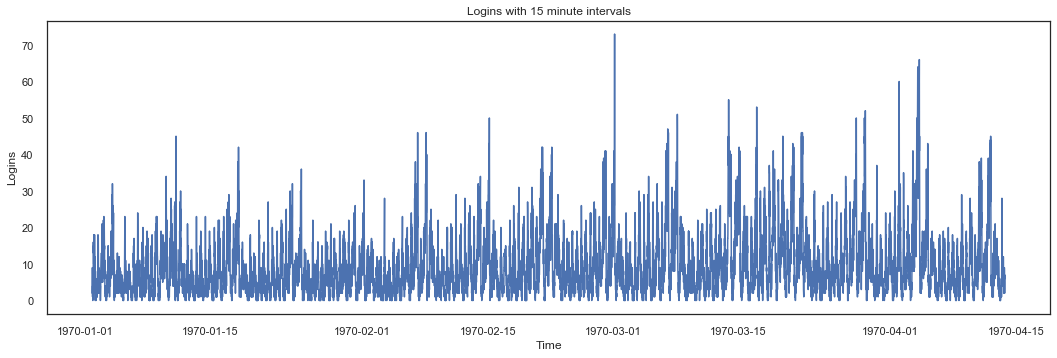

In [11]:
# scatterplot of the binned data
fig, ax = plt.subplots(figsize = (15,5))
plt.xlabel('Time')
plt.ylabel('Logins')
plt.tight_layout()
plt.title('Logins with 15 minute intervals')

plt.plot(logins_15.index, logins_15.login_count)
plt.show()

<div class="alert alert-info">
    
Although it looks like there is some underlying pattern, the pattern is not very clear to make a good conclusion.

In [12]:
# Binnning data by the day
logins_daily = logins.resample('D').sum()

In [13]:
# Appending day column
day_of_week = list(logins_daily.index.dayofweek)
logins_daily['day_of_week'] = day_of_week
logins_daily.head()

,login_count,day_of_week
login_time,,
1970-01-01,112,3
1970-01-02,681,4
1970-01-03,793,5
1970-01-04,788,6
1970-01-05,459,0


In [14]:
# Creating dataframes for weekend days
fridays = logins_daily.loc[logins_daily['day_of_week'] == 4]
saturdays = logins_daily.loc[logins_daily['day_of_week'] == 5]
sundays = logins_daily.loc[logins_daily['day_of_week'] == 6]

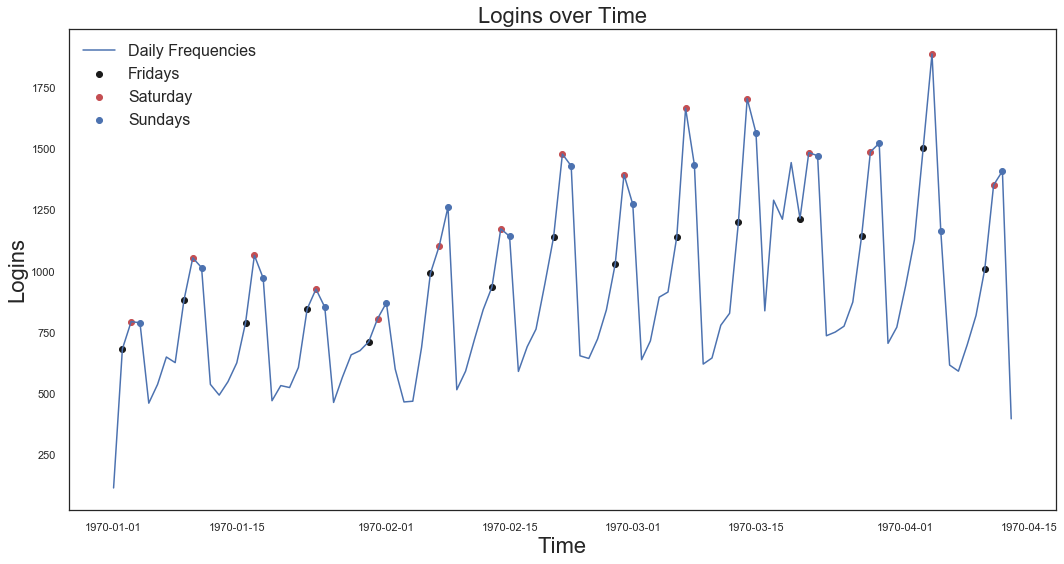

In [15]:
# line and scatterplot of the binned data
fig, ax = plt.subplots(figsize = (15,8))
plt.xlabel('Time', fontsize = 22)
plt.ylabel('Logins', fontsize = 22)
plt.title('Logins over Time', fontsize = 22)

plt.plot(logins_daily.index, logins_daily.login_count, label = 'Daily Frequencies')
plt.scatter(fridays.index, fridays.login_count, label = "Fridays", color = 'k')
plt.scatter(saturdays.index, saturdays.login_count, label = 'Saturday', color = 'r')
plt.scatter(sundays.index, sundays.login_count, label = "Sundays", color = 'b')


plt.legend(loc='upper left', fontsize = 16)
plt.tight_layout()

<div class="alert alert-info">
    
Here, the pattern is clearer. Friday seems to be the busiest day. Weedkends tend to be busier than weekdays.

In [16]:
# resampling index hourly
daily_logins = logins.resample('H').sum()
# add column with just the hour (omiting the date)
daily_logins['hour'] = [time.hour for time in daily_logins.index]

In [17]:
# creating dataframe of the total number of logins for each hour of each day
hourly_logins = pd.pivot_table(daily_logins, values = 'login_count', index = 'hour', aggfunc=np.sum)

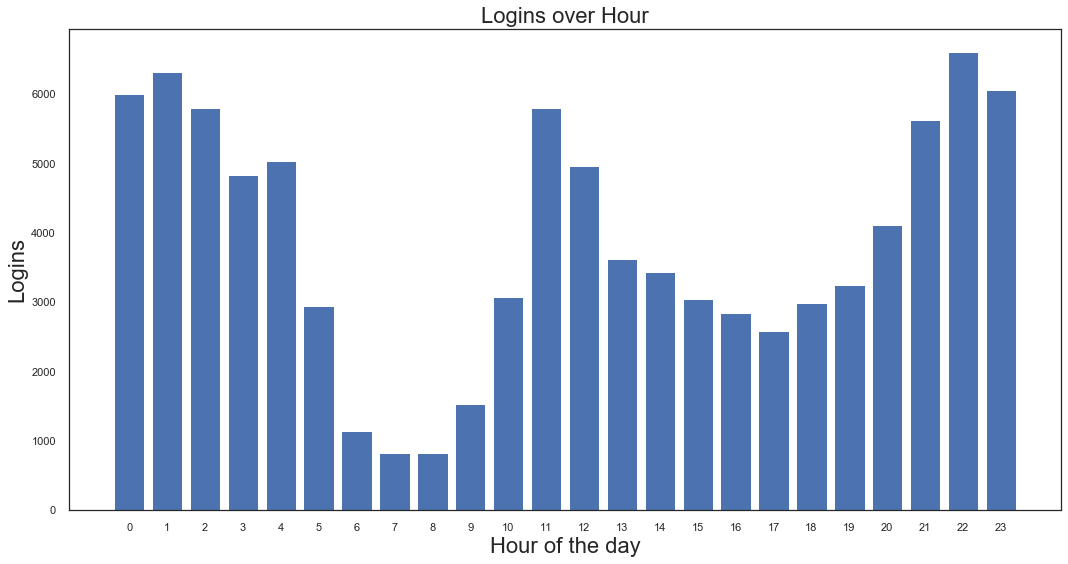

In [18]:
# histograms of logins per hour
fig, ax = plt.subplots(figsize = (15,8))

plt.bar(hourly_logins.index, hourly_logins.login_count)

plt.xlabel('Hour of the day', fontsize = 22)
plt.ylabel('Logins', fontsize = 22)
plt.title('Logins over Hour', fontsize = 22)
plt.xticks(hourly_logins.index)
plt.tight_layout()

<div class="alert alert-info">

The busiest hour is 10-11pm. There are 2 busy time brackets from 8pm-5am and 11am-1pm.

<H2> Part 2 ‑ Experiment and metrics design </H2>

<p>
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
</p>

<p>
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
    <ol>
        <li> What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</li>
        <li> Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
            <ul>
                <li> how you will implement the experiment</li>
                <li> what statistical test(s) you will conduct to verify the significance of the observation</li>
                <li> how you would interpret the results and provide recommendations to the city operations team along with any caveats.</li> 
</ul>
    </ol>

<b>Change in utilization</b> of the toll bridge on weekdays can be a good key measure of success of the experiement.

This experiment assumes that the change is calculable either using the reimbursements filed by the driver partners or using the GPS locations while passing over the bridge.  

In order to answer the above questions we can use the following hypothesis tests:
1. H0: There is NO DIFFERENCE between the mean number of cars entering the bridge from Gotham during weekday nights, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

   H2: There is an INCREASE in the mean number of cars entering the bridge from Gotham during weekdays nights, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

2. H0: There is NO DIFFERENCE between the mean number of cars entering the bridge from Metropolis during weekdays during the day, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.

   H2: There is an INCREASE in the mean number of cars entering the bridge from Metropolis during weekdays during the day, two weeks before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered. 

We can use a one-tailed Z-test to determine the p-value of each hypothesis. 

If the p-value is less than 0.05 for BOTH tests we reject the null hypotheses and recommend the reimbursement program continue.

If the p-value is greater than 0.05 for BOTH tests we fail to reject the null hypotheses and recommend that a different program be developed to increase partner driving between the two cities.

If the p-value is mixed, so only one hypothesis has a p-value less than 0.05 we recommend that the analysis is inconclusive and that further investigation is needed.

<H2> Part 3 ‑ Predictive modeling </H2>

<p>
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
</p>

<p>
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
</p>

The data is in the attached file ultimate_data_challenge.json.
    <ol>
        <li> Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?</li>
        <li> Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.</li>
        <li> Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).</li>
                
   </ol>

In [22]:
# Getting the users data
users = pd.read_json('ultimate_data_challenge.json')

In [23]:
# convert dates to datetime objects
users['signup_date'] = pd.to_datetime(users['signup_date'])
users['last_trip_date'] = pd.to_datetime(users['last_trip_date'])

# find the date the data was pulled
pull_date = users.last_trip_date.max()

# determine 30 days previous to the pull day
cut_off_day = pull_date - pd.Timedelta('30 days')

In [24]:
# Appending active boolean column
users['active'] = np.where(users['last_trip_date']>cut_off_day, 1, 0)

In [25]:
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


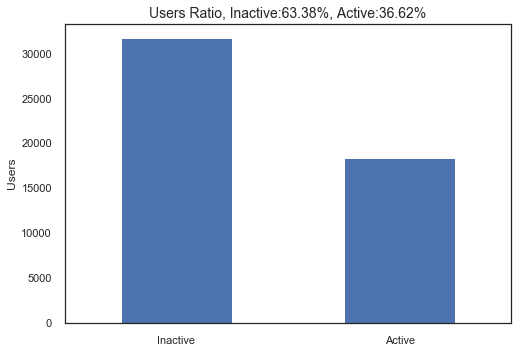

In [28]:
# Plotting the users ratio based on activity
ax = users.active.value_counts(dropna=False).plot(kind='bar')

plt.title(f"Users Ratio, Inactive:{len(users[users.active==0])/len(users) * 100:.2f}%, Active:{len(users[users.active==1])/len(users) * 100:.2f}%", 
          fontsize=14)
plt.ylabel('Users')
plt.tick_params(axis='x', rotation=0)
ax.set_xticklabels(['Inactive', 'Active'])
plt.show()

<div class="alert alert-info">

<b>36.62%</b> of the users are active or been retained.

In [29]:
# Transforming ultimate_black_user column to boolean of 1 and 0
dict_black_user = {True:1, False:0}
users.ultimate_black_user.replace(dict_black_user, inplace=True)

In [31]:
# Transforing categorical columns
dummy = pd.get_dummies(data=users, columns=['city', 'phone'])

In [32]:
# Dropping the target variable and dates
X = dummy.drop(['active', 'signup_date', 'last_trip_date'], axis=1)

In [33]:
# The 2 ratings columns have null values, we fill those with their respective means
X = X.fillna(X.mean())

In [34]:
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,1,1,0


In [35]:
# Target variable
y = users['active']

In [36]:
# Test-Train split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [40]:
# Importing machine learning and related libraries
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
import scikitplot as skplt
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [41]:
kfold = StratifiedKFold(n_splits=10)

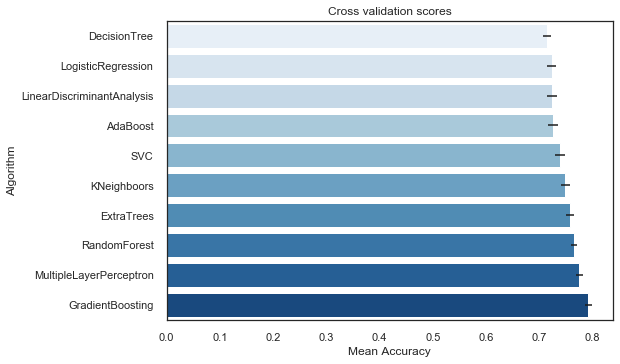

In [42]:
# Modeling step Test differents algorithms 
random_state = 42
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state, max_iter=1000))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state, max_iter=1000))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=y_train, scoring="accuracy", cv=kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

accuracies = []
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    accuracies.append(accuracy_score(y_test, classifier.predict(X_test)))

cv_res = pd.DataFrame({"CrossValMeans":cv_means,
                       "CrossValerrors":cv_std,
                       "TestingAccuracy":accuracies,
                       "Algorithm":["SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees", "GradientBoosting",
                                    "MultipleLayerPerceptron", "KNeighboors", "LogisticRegression",
                                    "LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res.sort_values(by=['CrossValMeans']), palette="Blues", orient="h", **{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

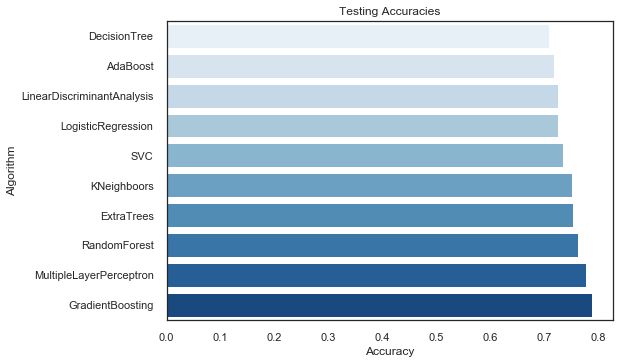

In [43]:
g = sns.barplot("TestingAccuracy", "Algorithm", data=cv_res.sort_values(by=['TestingAccuracy']), palette="Blues", orient="h")
g.set_xlabel("Accuracy")
g = g.set_title("Testing Accuracies")

In [44]:
cv_res[['Algorithm', 'CrossValMeans', 'CrossValerrors', 'TestingAccuracy']]

,Algorithm,CrossValMeans,CrossValerrors,TestingAccuracy
0,SVC,0.739143,0.007029,0.735400
1,DecisionTree,0.713971,0.008808,0.708800
2,AdaBoost,0.726000,0.009936,0.718867
3,RandomForest,0.765486,0.009246,0.762400
4,ExtraTrees,0.757457,0.009229,0.754267
5,GradientBoosting,0.791629,0.008216,0.788133
6,MultipleLayerPerceptron,0.775086,0.008045,0.777800
7,KNeighboors,0.748971,0.005463,0.750733
8,LogisticRegression,0.723200,0.007079,0.725867
9,LinearDiscriminantAnalysis,0.723686,0.006716,0.725533


<div class="alert alert-info">
    
We see that Gradient Boosting Classifier is the best performing model with the best validation as well as testing accuracy. We will further tune some hyperparameters for this classifier to see if we can see any improvements.

In [45]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()

# Search grid for optimal parameters
gb_param_grid = {'loss' : ["deviance"],
                 'n_estimators' : [100, 200, 300],
                 'learning_rate': [0.1, 0.05, 0.01],
                 'max_depth': [4, 8],
                 'min_samples_leaf': [100, 150],
                 'max_features': [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
gsGBC.fit(X_train,y_train)
GBC_best = gsGBC.best_estimator_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 22.4min finished


In [46]:
GBC_best

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=8,
                           max_features=0.3, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=100, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [47]:
# Validation accuracy of the best model
gsGBC.best_score_

0.7953142857142858

In [48]:
# Testing accuracy of the best model
accuracy_score(y_test, GBC_best.predict(X_test))

0.7944

<div class="alert alert-info">
    
We see a little improvement upon tuning the hyperparameters.

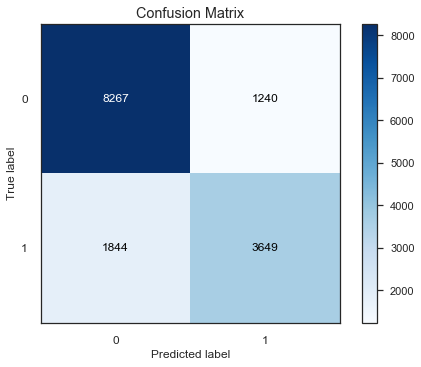

In [49]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, GBC_best.predict(X_test))

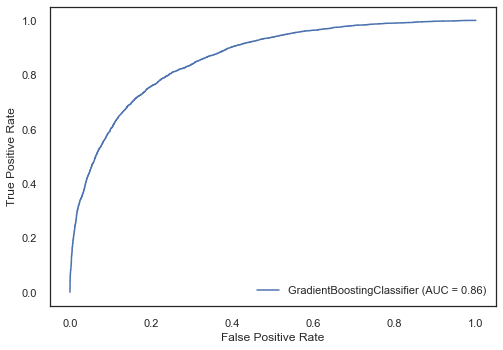

In [50]:
# ROC Plot
metrics.plot_roc_curve(GBC_best, X_test, y_test)

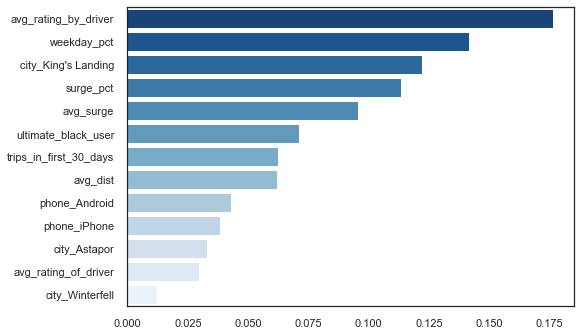

In [51]:
indices = np.argsort(GBC_best.feature_importances_)[::-1]
sns.barplot(y=X.columns[indices],x=GBC_best.feature_importances_[indices], palette="Blues_r", orient='h')

<div class="alert alert-info">
    
The user’s average rating over all of their trips and the percent of the user’s trips occurring during a weekday were the most influential features for this model. An overall improvement in the quality of service by Ultimate Technologies and it's driver partners can help create better experience to the users and their average rating motivating them to log in more frequently. Additionally, encouraging the users to use the app for their regular weekday activities will help to retain them as well.